In [1]:
# Analyse :

# IMPORTS :

import os
import pandas as pd
from pandas import *
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import *
from tensorflow.python.keras import optimizers as opt
import matplotlib.pyplot as plt
%matplotlib inline

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def Analyse_One(y_actual,y_pred,index,name,n_analyse):
    
    curr_analyse = pd.DataFrame()
    curr_analyse['Date'] = index
    curr_analyse.set_index(['Date'],inplace=True)
    
    curr_analyse['Y'] = y_actual
    curr_analyse['P'] = y_pred
    
    # RMSE :
    rmse = ((y_pred - y_actual) ** 2).mean() ** .5
    
    # MAE :
    mae = np.mean(abs(y_actual-y_pred))
    
    # MAPE :
    mape =  mean_absolute_percentage_error(y_actual, y_pred)
    
    curr_analyse['RMSE'] = rmse
    curr_analyse['MAE'] = mae
    curr_analyse['MAPE'] = mape
    
    
    # Export / Save :
    
    outdir = r"C:\Users\bapti\Documents\Equancy\Machine learning\Bench\1"
    outdir = outdir[:-1]
    outdir = outdir + name
    
    outname = name + "_" + str(n_analyse) + ".csv"

    
    if not os.path.exists(outdir):
        os.mkdir(outdir)

    fullname = os.path.join(outdir, outname)    

    curr_analyse.to_csv(fullname)
    
    
def Compile (index,name,n_it):
    
    
    
    
    adress = r"C:\Users\bapti\Documents\Equancy\Machine learning\Bench\1"
    adress = adress[:-1]
    adress = adress + name
    
    
    
    outname_perso = name + "_0.csv"
  
    
    if not os.path.exists(adress):
        os.mkdir(adress)

    full_dir_0 = os.path.join(adress, outname_perso)
    
    
    comp_analyse = pd.read_csv(full_dir_0)
    
    
    
    for i in range(1,n_it):
    
        
    
        outname_perso = name +"_" + str(i) + ".csv"
        
        full_dir = os.path.join(adress, outname_perso)
        
        curr_data = pd.read_csv(full_dir)
        
        curr_sum = pd.DataFrame()
        
        
        
        list_modif_str = ['Y','P',"RMSE","MAE","MAPE"]
        
        for text in list_modif_str:
            ty1 = text + "1"
            ty2 = text + "2"
            
            curr_sum[ty1] = comp_analyse[text]
            curr_sum[ty2] = curr_data[text]
            comp_analyse[text] = curr_sum[[ty1, ty2]].mean(axis=1)
            
            
     # Export / Save :
    
    
    
    
    outname = name + "_final.csv"

    
    if not os.path.exists(adress):
        os.mkdir(adress)

    fullname = os.path.join(adress, outname)    

    comp_analyse.to_csv(fullname)
    
    
    
    
def affichage(name):
    
    adress = r"C:\Users\bapti\Documents\Equancy\Machine learning\Bench\1"
    adress = adress[:-1]
    adress = adress + name
    
    outname_perso = name + "_final.csv"
    
    full_dir = os.path.join(adress, outname_perso)
        
    curr_data = pd.read_csv(full_dir)
    
    title = 'EDF Prediction _ ' + name
    
    
    plt.figure(figsize=(10,6))
    
    
    plt.plot(curr_data['Y'], color='blue', label='Actual')
    plt.plot(curr_data['P'] , color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Global_active_power')
    plt.legend()
    
    text_fig = 'rmse = ' + str(curr_data['RMSE'][0]) + "\n"
    text_fig += 'mae = ' + str(curr_data['MAE'][0]) + "\n"
    text_fig += 'mape = ' + str(curr_data['MAPE'][0]) + "\n"
    text_fig += 'epochs = 2'
    
    plt.figtext(0.5, -0.2, text_fig, ha="center", fontsize=18, bbox={"facecolor":"cyan", "alpha":0.5, "pad":5})
    
    
    name_doc = name + ".pdf"
    
    full_save = os.path.join(adress, name_doc)
    
    plt.savefig(full_save, bbox_inches = "tight")  
    
    plt.show()
    
    
    
def Test_method(df, test_size,pred,n_it,name):
    
    index = df.index[-test_size:]
    
    for i in range(n_it):
        y_actual,y_pred = pred(df, test_size)
        Analyse_One(y_actual,y_pred,index,name,i)
    
    
    Compile (index,name,n_it)
    affichage(name)

In [2]:
# Data :

df = pd.read_csv('Days.csv')
df["Date"] = pd.to_datetime(df['timestamp'])
df.set_index(['Date'],inplace=True)

df = pd.DataFrame(df, columns=['Y'])



In [3]:
# GRU (RNN) :

def GRU_model (df, test_size):
    
    # Prepare Data :
    
    index = df.index[-test_size:]

    shifted_df = df.shift()

    concat_df = [df,shifted_df]

    data = pd.concat(concat_df,axis = 1)
    data.fillna(0, inplace = True)



    data = np.array(data)

    train, test = data[0:-test_size], data[-test_size:]
    
    
    

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)

    

    # train data 
    y_train = train_scaled[:,-1] 
    X_train = train_scaled[:,0:-1] 
    X_train = X_train.reshape(len(X_train),1,1)
    # données de test 
    y_test = test_scaled[:,-1] 
    X_test = test_scaled[:,0:-1]
    
    
    
    
    # Model :

    model = Sequential()
    model.add(GRU(75, input_shape=(1,1)))
    model.add(Dense(2))  
    opt = keras.optimizers.Adam(learning_rate=0.01) #learning_rate=0.001
    model.compile(loss='mean_squared_error', optimizer= opt, metrics = ['accuracy'])
    model.fit(X_train, y_train, epochs=2, batch_size=20, shuffle=False)
    
    
    
    X_test = X_test.reshape(X_test.size,1,1)
    
    
    y_pred = model.predict(X_test)
    
    
    predictions_trad = scaler.inverse_transform(y_pred)

    predictions_col = []

    for i in predictions_trad :
        predictions_col.append(i[0])

    
    dic = {'Y': predictions_col}

    y_pred = pd.DataFrame(data = dic)

    y_pred['Date'] = index

    y_pred.set_index(['Date'],inplace=True)
    
    
    
    
    
    
    return df['Y'][-test_size:].values,y_pred.values

In [4]:
# LSTM_Keras :

# IMPORTS :

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


def LSTM_Keras_model (df, test_size):
    
    df_arg = df
    
    train_size = df.size - test_size
    
    # Data Normalization :
    scaler = MinMaxScaler(feature_range = (0, 1))

    df = scaler.fit_transform(df)
    
    features_set = []
    labels = []

    # On fait des groupes de 60
    # (l'article disait que por prévoir les stocks d'Apple c'est ce qu'il avait de meilleur avec ses test)
    for i in range(0, test_size):
        features_set.append(df[train_size+i-60:train_size+i, 0])
        labels.append(df[train_size+i, 0])

    features_set, labels = np.array(features_set), np.array(labels)

    # On formate les données pour le LSTM :
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
    
    
    # Création - LSTM :

    # Classe du modèle :
    model = Sequential()

    # Layer 1 - LSTM 50 units:
    model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

    # Dropout :
    # On oublie constamment une partie pour éviter le surentraînement
    model.add(Dropout(0.2))

    # On ajoute de la même manière 3 autre couche :
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # On veut une sortie on mets donc une couche dense avec 1 neurone en sortie
    model.add(Dense(units = 1))
    
    # Compilation du LSTM :

    # On utilise l'optimiseur adam
    # Erreur quadratique moyenne comme fonction d'ajustement

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Entraînement du modèle :

    model.fit(features_set, labels, epochs = 2, batch_size = 32)
    
    
    
    # Préparation des données de test :

    
    test_inputs = df_arg['Y'][-test_size-60:].values

    test_inputs = test_inputs.reshape(-1,1)
    test_inputs = scaler.transform(test_inputs)

    test_features = []
    for i in range(60, 60+test_size):
        test_features.append(test_inputs[i-60:i, 0])

    # Mise au format 3D :
    test_features = np.array(test_features)
    
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Prédiction :

    predictions = model.predict(test_features)
    predictions = scaler.inverse_transform(predictions)
    
    return df_arg['Y'][-test_size:].values,predictions

Epoch 1/2
51/51 [==============================] - 2s 2ms/step - loss: 0.0379 - accuracy: 9.9404e-04
Epoch 2/2
51/51 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.0020
Epoch 1/2
51/51 [==============================] - 2s 2ms/step - loss: 0.0379 - accuracy: 0.0030
Epoch 2/2
51/51 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 0.0020
Epoch 1/2
51/51 [==============================] - 2s 2ms/step - loss: 0.0389 - accuracy: 0.0020
Epoch 2/2
51/51 [==============================] - 0s 2ms/step - loss: 0.0190 - accuracy: 0.0020
Epoch 1/2
51/51 [==============================] - 2s 2ms/step - loss: 0.0401 - accuracy: 0.0020
Epoch 2/2
51/51 [==============================] - 0s 2ms/step - loss: 0.0195 - accuracy: 0.0020
Epoch 1/2
51/51 [==============================] - 2s 2ms/step - loss: 0.0400 - accuracy: 0.0020
Epoch 2/2
51/51 [==============================] - 0s 2ms/step - loss: 0.0194 - accuracy: 9.9404e-04
Epoch 1/2
51/51 [=====

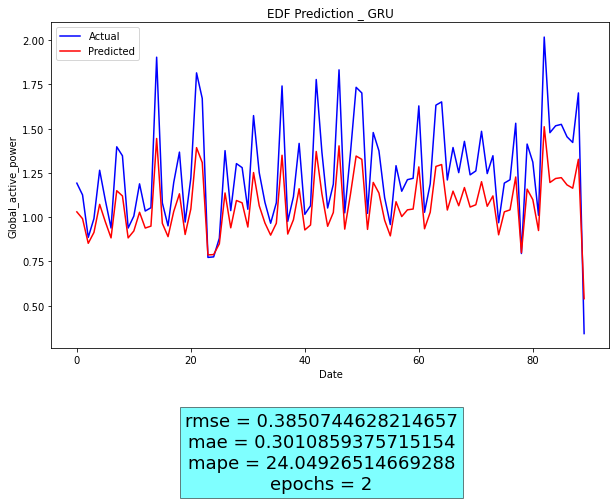

Epoch 1/2
3/3 [==============================] - 6s 84ms/step - loss: 0.1382
Epoch 2/2
3/3 [==============================] - 0s 78ms/step - loss: 0.0330


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 86ms/step - loss: 0.1504
Epoch 2/2
3/3 [==============================] - 0s 82ms/step - loss: 0.0452


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 88ms/step - loss: 0.1617
Epoch 2/2
3/3 [==============================] - 0s 83ms/step - loss: 0.0471


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 91ms/step - loss: 0.1434
Epoch 2/2
3/3 [==============================] - 0s 82ms/step - loss: 0.0395


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 90ms/step - loss: 0.1185
Epoch 2/2
3/3 [==============================] - 0s 84ms/step - loss: 0.0268


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 87ms/step - loss: 0.1459
Epoch 2/2
3/3 [==============================] - 0s 82ms/step - loss: 0.0362


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 95ms/step - loss: 0.1384
Epoch 2/2
3/3 [==============================] - 0s 101ms/step - loss: 0.0334


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 7s 90ms/step - loss: 0.1498
Epoch 2/2
3/3 [==============================] - 0s 84ms/step - loss: 0.0376


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 97ms/step - loss: 0.1403
Epoch 2/2
3/3 [==============================] - 0s 96ms/step - loss: 0.0397


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Epoch 1/2
3/3 [==============================] - 6s 84ms/step - loss: 0.1595
Epoch 2/2
3/3 [==============================] - 0s 78ms/step - loss: 0.0594


C:\Users\bapti\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


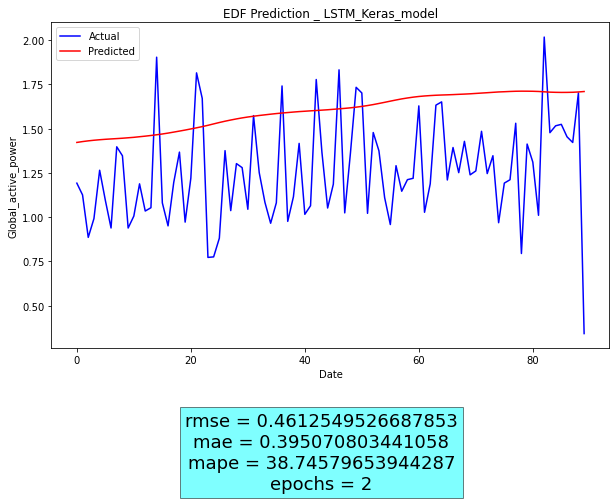

In [5]:
# Final Process :

Test_method(df, 90,GRU_model,10,"GRU")
Test_method(df, 90,LSTM_Keras_model,10,"LSTM_Keras_model")